# Trainieren des Sentimentmodells

In diesem Notebook wird ein Modell trainiert, welches Tweets live auf ihre Stimmung bewerten soll. Dafür wird ein Deep Neural Network erstellt, welches mit 1.6 Millionen Tweets trainiert wird. Hierbei handelt es sich um ein Klassifikationsproblem, es soll letztendlich entschieden werden, ob ein Tweet negativ (0), oder positiv (1) gestimmt ist.

### Technologien

Für das Modell wird [Tensorflow](https://www.tensorflow.org/) verwendet, zum plotten von Informationen nutzen wir [Matplotlib](https://matplotlib.org/stable/index.html) und zum verarbeiten von Daten [Pandas](https://pandas.pydata.org/). Weiterhin werden weitere utilities von [sklearn](https://scikit-learn.org/stable/) übernommen.

### Setup

Um dieses Notebook zu benutzen müssen Python 3.x und folgende Packages installiert werden:

* tensorflow
* matplotlib
* pandas
* sklearn

Das Datenset fürs trainieren kann über [diesen Link](https://www.dropbox.com/s/ur7pw797mgcc1wr/tweets.csv?dl=0) heruntergeladen werden. Dabei muss die Datei "tweets.csv" in diesen Ordner abgelegt werden.

### Datenset

Um nun das Modell möglichst gut darauf zu trainieren reale Tweets zu bewerten haben wir uns für ein Datenset entschieden, welches 1.6 Millionen bereits gelabelte Tweets enthält, dieses kann [hier](https://www.kaggle.com/kazanova/sentiment140) gefunden werden

In [61]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import feature_column
from tensorflow.keras import layers

### Laden des Datensets

Mithilfe von pandas wird das Datenset geladen, dabei werden nur die erste und die letzte Spalte geladen, da nur diese für uns von Interesse sind. Da es sich bei der ersten Spalte um die Stimmung des Tweets handelt wird diese mit "targets" gelabelt, die letzte Spalte beihaltet den eigentlichen Tweet, diese wird mit "text" gelabelt.

In [2]:
dataframe = pd.read_csv("./tweets.csv", usecols=[0, 5], names=["target", "text"])

Da das Datenset sortiert ist muss es randomisiert werden. Falls dies nicht gemacht werden würde, hätte dies einen negativen Einfluss auf das Lernen, da alle Daten die zuerst reinkommen negativ gelabelt sind. Somit würde das Modell denken, alles wäre negativ und würde sich entsprechend darauf einstellen, kommen dann letztendlich alle positiven Daten würde das Modell denken es gäbe nur positive Daten und würde letztendlich bei richtigen Daten immer eine positive Stimmung predicten, was nicht der Realtität entsprechen würde.

In [3]:
dataframe = shuffle(dataframe)

Zum validieren, dass das Datenset auch korrekt geladen wurde, es sollte eine Tabelle mit den ersten fünf Einträgen zu sehen sein

In [4]:
dataframe.head()

,target,text
1398959,4,@Dan88w guess the episode
613489,0,@Matthews42 Mrs. Chandler said she died in her...
15152,0,@AngelIbarra i only get that when i'm around a...
952391,4,@Johnage hahahah i know. i eat it anyhow. but ...
114482,0,It's so hot. I want to take a shower but I'm t...


Um das trainieren des Modells zu überwachen und um die Accuracy des Modells hinterher zu errechnen wird das Datenset in drei Teile unterteilt. In einem Verhältnis von 80:20 wird das Datenset in Trainingsdaten und Testdaten unterteilt. Trainingsdaten dienen hier ausschließlich zum trainieren des Modells, Testdaten werden nach dem Trainieren dazu verwendet, um die Accuracy des Modells zu errechnen, diese sollen reale Daten simulieren. Der Grund, warum das Verhältnis stark auf der Seite der Trainingsdaten liegt, ist, weil mehr Trainingsdaten ein besseres Ergebnis versprechen, dabei muss die Anzahl der Daten bei den Testdaten nicht hoch sein, um die Accuracy zu bestimmen.

Weiterhin werden die Trainingsdaten wiederum in Trainingsdaten und Validationsdaten mit einem Verhältnis von 80:20 unterteilt. Die Validationsdaten werden dazu verwendet um das Training zu überwachen, nach jedem Epoch (Trainingsschritt) wird damit die aktuelle Accuracy bestimmt.

In [5]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train), 'training tweets')
print(len(val), 'validation tweets')
print(len(test), 'test tweets')

1024000 training tweets
256000 validation tweets
320000 test tweets


Da jetzt das Datenset entsprechend aufgeteilt wurde kann es nun in das verlangte Tensorflowformat gebracht werden. Dafür werden die Features (text) und die Labels (labels) klar definiert. Zusätzlich wird eine Batchsize definiert, welche Daten gruppiert um das Lernen zu beschleunigen.

In [6]:
def df_to_dataset(dataframe, batch_size):
  dataframe = dataframe.copy()
  texts = dataframe.pop('text')
  labels = dataframe.pop('target')
  return tf.data.Dataset.from_tensor_slices((texts, labels)).batch(batch_size)

In [7]:
batch_size = 320

raw_train_ds = df_to_dataset(train, batch_size)
raw_val_ds = df_to_dataset(val, batch_size)
raw_test_ds = df_to_dataset(test, batch_size)

Um zu validieren, dass die Konvertierung geklappt hat werden die ersten drei Einträge ausgelesen

In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Tweet:", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Tweet: b"@YEBies I gotta go to work soon though (for free) so I won't have time "
Label: 0
Tweet: b'Oh my gosh there are fireflies everywhere! '
Label: 4
Tweet: b"@IamMaxatHotSpot There's also pixi lights. Not as cool looking as electroluminescent wire, but it's even easier to use! "
Label: 4


Hier werden die Daten für das Modell normalisiert. Dies ist wichtig um unnötige Duplikate zu vermeiden, wie z.B. Wörter, die in manchen Tweets groß und in anderen wieder klein geschrieben werden. Zusätzlich können Usernames, welche mit "@" beginnen normalisiert werden, da der genaue username unwichtig für die sentiment prediction ist.

In [101]:
def normalize_data(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase, '@(\w*)|(\\n)|(https:\/\/t\.co[\w\/]*)', '')

Nun können die Texte vektorisiert werden. Da ein neuronales Netz nicht mir Wörtern und Buchstaben arbeiten kann, müssen diese in Zahlen umgewandelt werden. Dafür werden die Tweets in Vektoren umgewandelt. Die Größe des Vektors wird dabei mit sequence_length definiert. Die Größe der sequence_length, also letztendlich die Größe des Vektors sollte in der Regel so groß sein, dass alle Wörter eines Tweets hereinpassen. Da die Anzahl an Zeichen auf 280 pro Tweet limitiert ist, und die durschnittliche Anzahl der Zeichen pro Wort im Englischen bei 5 liegt wird die sequence_length mit 56 definiert.

Hier erhält jedes Wort eine fortlaufende Id, die Reihenfolge wird darüber bestimmt, welche Wörter zuerst vektorisiert werden. Dabei können aufgrund max_features maximal 10000 Wörter eingelesen werden, alle weiteren werden ignoriert, diese Menge an Vokabeln sollte aber ausreichen, da in der Alltagssprache lediglich zwei bis drei tausend Wörter verwendet werden. Somit kann jedes Wort zu einer Id gemappt werden, sodass man letztendlich ganze Sätze in einem Vektor abbilden kann. Damit lösen wir auch das Problem, dass ein neuronales Netz immer die gleiche Inputgröße benötigt, da die Vektorengröße immer der sequence_length enstpricht.

Dafür wird hier ein Vektorlayer erstellt. Gleichzeitig können hier die Daten normalisiert werden.

In [90]:
max_features = 10000
sequence_length = 56

vectorize_layer = TextVectorization(
    standardize=normalize_data,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Hier werden die Trainingsdaten eingelesen, sodass die 10000 features gefüllt werden können, somit haben wir für die Tweets ein eigenes "Wörterbuch"

In [92]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Mit der Methode können wir gleich alle Datensets vektorisieren. Hier normalisieren wir noch das Label, sodass das Label eine Range von 0 bis 1, anstatt von 0 bis 4 hat. 

In [93]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), int(label / 4)

Um zu testen, ob das vektorisieren der Tweets funktioniert können wir den ersten Tweet aus dem ersten Batch auslesen und vektorisieren.

In [94]:
text_batch, label_batch = next(iter(raw_train_ds))
text, label = text_batch[0], label_batch[0]
print(text)
print(label)
print(vectorize_text(text, label))

tf.Tensor(b"@YEBies I gotta go to work soon though (for free) so I won't have time ", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
(<tf.Tensor: shape=(1, 56), dtype=int64, numpy=
array([[   2,  278,   36,    3,   55,  256,  185, 4642,    1,   15,    2,
         230,   16,   65,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]])>, 0)


Mithilfe des Vektorlayers können wir die Ids wieder zu Wörtern zurückmappen, außerdem können wir die Größe unseres Wörterbuchs auslesen

In [95]:
print("1234 ---> ", vectorize_layer.get_vocabulary()[1234])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1234 --->  sort
Vocabulary size: 10000


Nun vektorisieren wir alle benötigten Datensets

In [96]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Aus Performancegründen können die Datensets weiter aufbereitet werden. Mit `.cache()` bleiben die Daten im Arbeitsspeicher, nachdem diese von der Festplatte geladen wurden. Somit kann sichergestellt werden, dass das Laden der Daten nicht das Bottleneck beim Training sein wird.

Mit `.prefetch()` können die Daten gleichzeitig mit dem Lernen präprozessiert werden.

In [97]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Schließlich definieren wir das eigentliche Modell. Die erste Layer ist ein Embedding-Layer. Dies sorgt dafür, dass jedes Wort wiederum einen eigenen Vektor erhält, dieser stellt die Bedeutung des Wortes dar. Diese Vektoren werden mit dem Modell mit der Zeit trainiert. Diese Embeddinglayer fügt eine weitere Dimension zum Outputvektor hinzu. Hier definieren wir mit der embedding_dim die Größe der Layers, das bedeutet, dass es 32 Nodes pro Layer gibt.

Für die nächste Layer wird `GlobalAveragePooling1D` verwendet. Diese reduziert die Dimension wieder um 1 und verrechnet dabei alle Informationen, sodass nichts verloren geht. Der Outputvektor wird dabei wieder auf eine feste Länge normalisiert.

Anschließend folgt ein fully-connected 32 Dense-Layer. Hier wurde eine Dropoutrate festgelegt, um Overfitting zu verhindern. Das Ziel hier ist random ausgewählte Nodes auf 0 zu setzen, damit das anspassen der Weights der einzelnen Nodes beim lernen gefördert wird.

Letztendlich wird das letzte Layer mit einem Dense Layer zu einer einzigen Node verknüpft. Diese hat eine Range von 0 bis 1 und gibt das Ergenis aus.

Wir können nun noch mit `.summary()` das Modell verifizieren.

In [98]:
embedding_dim = 32

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320032    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 320,065
Trainable params: 320,065
Non-trainable params: 0
_________________________________________________________________


Für das Trainieren müssen noch ein paar Parameter definiert werden. Für die Berechnung des Fehlers (loss) verwenden wir die `BinaryCrossentropy` Funktion. Der Fehler gibt uns an, wie weit wir von der richtigen Prediction weg sind. Wir haben uns dafür entschieden, da wir einen sogenannten Binary Classifier haben, der uns eine Wahrscheinlichkeit von 0 bis 1 als Ergebnis gibt. Dabei arbeiten wir mit Logits, sodass die Labels als sogennante Logits betrachtet werden, diese Darstellung als Wahrscheinlichkeit verspricht laut Tensorflow größere numerische Stabilität.

Weiterhin verwenden wir für den Optimierungsalgorithmus den `Adam-Optimizer`. Wir haben uns für den Adam-Optimizer, im Gegensatz zum klassischen Stochastic Gradient Descent Algorithmus entschieden, da sich die Learningrate beim Adam-Optimizer mit der Zeit automatisch anpasst. Das ist besonders praktisch bei Natural Language Processing, da hier die Gradients in der Regel sehr gering sind. Dabei wird die Learningrate basierend auf der vorherigen Änderung der Weights angepasst. Hier haben wir eine sehr kleine Learningrate definiert, da wir ein sehr großes Datenset haben und nicht zu schnell in das Problem von Overfitting laufen wollen, weshalb langsameres lernen, also ein langsameres Anpassen der Weights, hier passender ist.

In [99]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

Nun wird endlich das Modell trainiert. Dafür definieren wir mit epochs, wie oft wir über das Trainingsdatenset iterieren. Es werden in `model.fit()` die Trainingsdaten, die Validationsdaten und die Anzahl der Epochen angegeben. Tensorflow loggt den Fortschritt live in der Konsole aus, zusätzlich wird der Trainingsstatus in einem History-Objekt festgehalten.

In [100]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
3200/3200 [==============================] - 13s 4ms/step - loss: 0.6869 - binary_accuracy: 0.5841 - val_loss: 0.6546 - val_binary_accuracy: 0.6854
Epoch 2/10
3200/3200 [==============================] - 11s 3ms/step - loss: 0.6407 - binary_accuracy: 0.6940 - val_loss: 0.6025 - val_binary_accuracy: 0.7150
Epoch 3/10
3200/3200 [==============================] - 11s 3ms/step - loss: 0.5914 - binary_accuracy: 0.7222 - val_loss: 0.5637 - val_binary_accuracy: 0.7378
Epoch 4/10
3200/3200 [==============================] - 11s 3ms/step - loss: 0.5551 - binary_accuracy: 0.7441 - val_loss: 0.5356 - val_binary_accuracy: 0.7533
Epoch 5/10
3200/3200 [==============================] - 11s 4ms/step - loss: 0.5290 - binary_accuracy: 0.7587 - val_loss: 0.5159 - val_binary_accuracy: 0.7638
Epoch 6/10
3200/3200 [==============================] - 11s 3ms/step - loss: 0.5105 - binary_accuracy: 0.7684 - val_loss: 0.5026 - val_binary_accuracy: 0.7709
Epoch 7/10
3200/3200 [========================

Nachdem das Modell nur trainiert ist können wir es mit den vorher festgelegten Testdatensatz testen. Diese sollen wie bereits erwähnt echte Daten simulieren. Dabei erhalten wir mit `model.evaluate()` den Loss und die Accuracy, welche bei rund 80% liegt

In [102]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

1000/1000 [==============================] - 3s 2ms/step - loss: 0.4790 - binary_accuracy: 0.7850
Loss:  0.47895824909210205
Accuracy:  0.784974992275238


In dem History-Objekt können wir nun sehen, welche Daten Tensorflow für uns aufgezeichnet hat

In [103]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

Mithilfe von Matplotlib können wir den Loss plotten und beobachten, wie diese sich beim lernen verhalten hat. Optimalerweise sollte diese mit der Zeit runtergehen, da mit dem Anpassen der Weights das Modell immer genauere Aussagen treffen sollte und somit der Fehler immer geringer wird.

Wir können erkennen, dass dies tatsächlich der Fall ist, dabei fällt der Loss fast exponentiell. Logischerweise wird der Trainingsloss immer geringer, als Bestätigung für die Verbesserung des Modells dient hier die Validationloss. Diese ist fast gleich, sodass wir davon ausgehen können, dass die Anzahl der Fehlinterpretierungen tatsächlich geringer wurde.

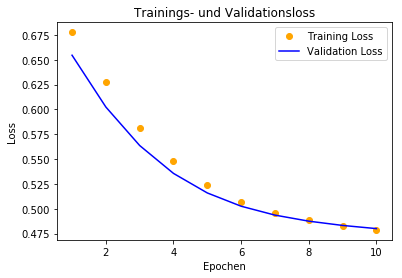

In [104]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'o', color='orange', label='Training Loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'blue', label='Validation Loss')
plt.title('Trainings- und Validationsloss')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.legend()

plt.show()

Das gleiche können wir auch für die Accuracy machen. Hier sollte im Optimalfall die Accuracy mit der Zeit steigen. Dieses Verhalten können wir wieder an unserem Modell erkennen. Hier erinnert der Graph an eine Sättigungskurve. Das liegt daran, dass es mit der Zeit immer schwerer wird das Modell noch mehr zu verbessern, da das Lernen letztendlich eine Optimierung ist, dessen Verbesserung im späteren Verlauf nur mit höheren Aufwänden zu erreichen ist.

An beiden Graphiken kann man jedoch gut erkennen, dass es zu keinem Overfitting kommt. Wenn wir die Accuracy betrachten, würde bei Overfitting die Accuracy der Testdaten weiter Ansteigen, während die Accuracy der Validationsdaten und die der Testdaten stagniert oder gar heruntergeht. Das gleiche würde analog mit dem Loss passieren.

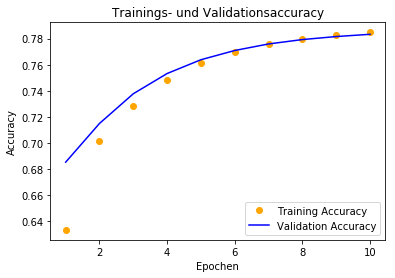

In [105]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'o', color='orange', label='Training Accuracy')
plt.plot(epochs, val_acc, 'blue', label='Validation Accuracy')
plt.title('Trainings- und Validationsaccuracy')
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Nun exportieren wir das fertige Modell. Da wir vorher die Texte vektorisiert haben, bevor sie in das Modell gegeben wurden, können wir hier ein Modell exportieren, welche die Texte beim Input vektorisiert. Dies macht uns jetzt das zukünftige Predicten einfacher. Zusätzlich fügen wir am Ende eine weitere Node mit einer Sigmoid Aktivierungsfunktion hinzu. Diese mappt uns alle Werte zwischen 0 und 1, sodass unsere definiert Sentiment Range eingehalten wird. Die Vektorisationlayer und die Sigmoid Node wurden beim lernen weggelassen, um die Effizienz zu erhöhen.

In [106]:
sentiment_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

Schließlich können wir ein paar Beispiele eingeben um zu sehen, was das Modell denkt. Dabei ist der erste Satz positiv, der zweite neutral und der letzte negativ. Anhand der Ergebnisse können wir sehen, dass das Modell ähnlich darüber denkt. Während der neutrale Satz mit rund 0.5 gewertet wird, wird der positive höher gewertet und der negative geringer.

In [107]:
examples = [
  "Today is a great day!",
  "This sentence is rather neutral",
  "This show is terrible!"
]

sentiment_model.predict(examples)

array([[0.8429991 ],
       [0.52510256],
       [0.42142162]], dtype=float32)

In [108]:
# technical analysis

# Anwenden auf Twitter Livedaten

blablabla

In [109]:
# pip install searchtweets-v2
from searchtweets import load_credentials, gen_request_parameters, collect_results
import numpy as np
from datetime import datetime
import matplotlib.dates as mdate

In [110]:
search_args = load_credentials("./.twitter_keys.yaml", yaml_key="search_tweets_v2")

In [111]:
max_tweets = 100

query = gen_request_parameters(
    "(ether OR eth OR ethereum OR cryptocurrency) -bot -app -is:retweet is:verified lang:en",
    tweet_fields="id,created_at,text",
    results_per_call=max_tweets)

In [113]:
tweets = list(reversed(collect_results(query, max_tweets=max_tweets, result_stream_args=search_args)))

print(tweets)

create_dates = []
tweet_texts = []

for tweet in tweets:
    if 'text' not in tweet:
        continue
    tweet_texts.append(tweet['text'])
    
    utc_time = datetime.strptime(tweet['created_at'], "%Y-%m-%dT%H:%M:%S.%fZ")
    epoch_time = (utc_time - datetime(1970, 1, 1)).total_seconds()
    create_dates.append(epoch_time)

[{'newest_id': '1367878564213891076', 'oldest_id': '1367808722756583428', 'result_count': 100, 'next_token': 'b26v89c19zqg8o3fosnu6xqqv0h6gerj4yhprtqwdhsot'}, {'created_at': '2021-03-05T12:06:26.000Z', 'id': '1367808722756583428', 'text': 'For only $100 per share, each investor was promised an eventual return of 1.15kgs in gold, worth over $45,000 as of January 2019. Each share was purchased through cryptocurrency including bitcoin (BTC). https://t.co/PsyFdv1JIh'}, {'created_at': '2021-03-05T12:07:44.000Z', 'id': '1367809049706835968', 'text': 'Cryptocurrency exchange Bybit announced Friday it will cease providing its services to customers from the U.K. following a regulatory ban.\n\nBy @Tanzeel_Akhtar \n\nhttps://t.co/bt3svfxhzg'}, {'created_at': '2021-03-05T12:13:10.000Z', 'id': '1367810414679977987', 'text': "#CNBCTV18IBLA | #FinanceMinister @nsitharaman says 'Govt wants to ensure there's a window for experiments in #Cryptocurrency space.' Adds 'There will be a very calibrated posit

In [114]:
sentiment = sentiment_model.predict(tweet_texts).flatten()

for i in range(5):
    d = create_dates[i]
    t = tweet_texts[i]
    p = sentiment[i]
    print("{} - {} - {}".format(d,t,p))

1614945986.0 - For only $100 per share, each investor was promised an eventual return of 1.15kgs in gold, worth over $45,000 as of January 2019. Each share was purchased through cryptocurrency including bitcoin (BTC). https://t.co/PsyFdv1JIh - 0.7179270386695862
1614946064.0 - Cryptocurrency exchange Bybit announced Friday it will cease providing its services to customers from the U.K. following a regulatory ban.

By @Tanzeel_Akhtar 

https://t.co/bt3svfxhzg - 0.7847133278846741
1614946390.0 - #CNBCTV18IBLA | #FinanceMinister @nsitharaman says 'Govt wants to ensure there's a window for experiments in #Cryptocurrency space.' Adds 'There will be a very calibrated position taken on cryptocurrency.' 
@ShereenBhan @FinMinIndia

#Leadersofchange https://t.co/YHEYA9INkf - 0.34002453088760376
1614946842.0 - #CNBCTV18IBLA | FM on NSE Glitch: SEBI Chief has given us a presentation on the #nseglitch; I am assured that such glitch will never be repeated. 

FM on Cryptocurrency: There will be a cal

In [115]:
def simple_moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[n:] - cumsum[:-n]) / float(n)

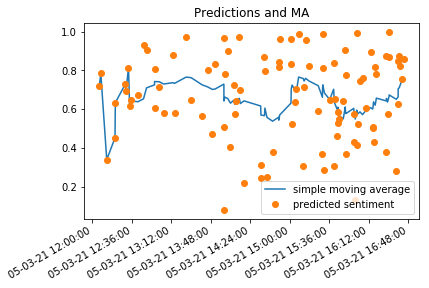

In [116]:
n = 10
sma = simple_moving_avg(sentiment, n)

for i in range(n - 1):
    sma = np.insert(sma, i, sentiment[i])
    
dates = mdate.epoch2num(create_dates)

fig, ax = plt.subplots()

ax.plot(dates, sma, label="simple moving average")
ax.plot(dates, sentiment, "o", label="predicted sentiment")

date_fmt = '%d-%m-%y %H:%M:%S'

date_formatter = mdate.DateFormatter(date_fmt)
ax.xaxis.set_major_formatter(date_formatter)

fig.autofmt_xdate()

plt.title('Predictions and MA')
plt.legend(loc='lower right')

plt.show()